# stress test Processing Time / delegations validators analysis


In [1]:
# !pip install pyhmy --upgrade
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from pyhmy import cli

In [2]:
def read_data(files, path):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if "PROPOSING NEW BLOCK" in line or "Successfully Proposed New Block" in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data, columns = ['blockNum', 'time', 'message'])
    df["message"] = df["message"].apply(lambda c: c.replace("-","").replace("=","").strip())
    pattern = re.compile('(.*?)\..*?')
    df['time'] = df['time'].apply(lambda c: re.findall(pattern, c)[0].replace("T"," "))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values(by=['time','message'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

In [4]:
def get_block_change_index(df):
    df['block_diff'] = (df['blockNum']-df['blockNum'].shift()).fillna(0).astype(int)
    index = df[df['block_diff'] < 0].index.tolist()
    index.insert(0,0)
    index.append(len(df))
    return index

In [5]:
def draw_time_graph(df, index):  
    
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")\
    + str(index) + "_processing_time_vs_block_height.html"
    png_path = html_dir
    print("png graphs saved in " + png_path)
    print('html graphs saved in ' + html_path)
    
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
        
#     colors = ["#00AEE9"]
#     fig = px.line(df[df['message'] == 'Successfully Proposed New Block'], \
#                   x="blockNum", y="time_diff", color='message', color_discrete_sequence=colors,
#                   title = 'Processing Time vs Block Height')
    fig = go.Figure()
    fig.add_trace(go.Scatter(
            x= df["blockNum"],
            y= df["time_diff"],
            mode='lines',
            name='processing time',
            line_color= "#85C1E9"
        ))

    for i in df.index.tolist():
        if (i+1) % 525 == 0:
            fig.add_shape(type="line", x0=df.iloc[i]["blockNum"], y0=0,x1=df.iloc[i]["blockNum"],y1=1,
                    line=dict(
                    width=0.5,
                    dash="dot",
                ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.update_layout(title = "Processing Time vs Block Height")
    
#     fig.show()
    fig.show(renderer="svg",width=800, height=500)
    fig.write_html(html_dir + str(index) + "_processing_time_vs_block_height.html")
    fig.write_image(png_path + str(index) + "_processing_time_vs_block_height.png",width=900, height=500)

In [6]:
def read_delegations(files, path):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if "paid out delegations" in line:
                        data.append(json.loads(line))
    return data

In [7]:
def delegation_processing(delegations):
    validators = []
    delegators = []
    for i in delegations:
        validators.append(len(i['count-track']))
        delegators.append(sum(i['count-track'].values()))

    df = pd.DataFrame(delegations, columns = ['block-number', 'epoch','time'])
    df['validators-number'] = validators
    df['delegators-number'] = delegators
    pattern = re.compile('(.*?)\..*?')
    df['time'] = df['time'].apply(lambda c: re.findall(pattern, c)[0].replace("T"," "))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values(by=['time'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

In [8]:
def get_epoch_change_index(df):
    df['epoch-diff'] = (df['epoch']-df['epoch'].shift()).fillna(0).astype(int)
    index = df[df['epoch-diff'] < 0].index.tolist()
    index.insert(0,0)
    index.append(len(df))
    return index

In [9]:
def draw_delegation_graph(df, index):  
    
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")\
     + str(index) + "_delegation_vs_block_height.html"
    png_path = fig_dir
    print("png graphs saved in " + png_path)
    print('html graphs saved in ' + html_path)
    
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
        
    fig = go.Figure()
    fig.add_trace(go.Scatter(
            x= df["block-number"],
            y= df["validators-number"],
            mode='lines',
            name='number of validators',
            line_color= "#F5B7B1"
        ))

    fig.add_trace(go.Scatter(
        x= df["block-number"],
        y= df["delegators-number"],
        mode = "lines",
        line_color = "#85C1E9",
        name='number of delegators'   
    ))
    

    for i in df.index.tolist():
        if (i+2) % 7 == 0:
            fig.add_shape(type="line", x0=df.iloc[i]["block-number"], y0=0,x1=df.iloc[i]["block-number"],y1=1,
                    line=dict(
                    width=0.5,
                    dash="dot",
                ))
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.update_layout(title = "Delegation Information vs Block Height")
    
#     fig.show()
    fig.show(renderer="svg",width=800, height=500)
    fig.write_html(html_dir + str(index) + "_delegation_vs_block_height.html")
    fig.write_image(png_path + str(index) + "_delegation_vs_block_height.png",width=1000, height=500)

In [10]:
def download_cli(path):
    env = cli.download()
    cli.environment.update(env)
    path = os.getcwd() + "/bin/hmy"
    cli.set_binary(path)

In [11]:
def get_top_validator(delegation, size):
    
    sorted_validator = sorted(delegation['count-track'].items(), key=lambda x: x[1], reverse = True)

    # call cli to change address cost a lot of time. Todo only change address for top ones.           
    new = []
    for v in sorted_validator[:size]:
        new.append(cli.single_call("hmy utility addr-to-bech32 " + v[0]).strip("\n"))
        
    # changing keys of dictionary 
    top_validator = dict(zip(new, list(dict(sorted_validator[:5]).values()))) 
    return top_validator

In [12]:
def draw_graph(new, new_del, index):
    
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")\
    + str(index) + "_delegation_vs_processing_time.html"
    png_path = fig_dir 
    print("png graphs saved in " + png_path)
    print('html graphs saved in ' + html_path)
    
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    trace1 = go.Scatter(
        x= new["blockNum"],
        y= new["time_diff"],
        mode='lines',
        name='processing time',
        line_color= "#66CDAA",
        text = new['time'],
        hovertemplate = "Processing Time: %{y}<br>" +
        "Block Height: %{x}<br>" +
        "UTC Time: %{text}<br>" +
        "<extra></extra>"
    )

    trace2 = go.Scatter(
        x= new_del["block-number"],
        y= new_del["validators-number"],
        mode='lines',
        name='number of validators',
        line_color= "#ffa07a",
        yaxis='y2',
        text = new_del['time'],
        customdata = new_del['epoch'],
        hovertemplate = 'Number of Validators: %{y}<br>' +
        'Block Height: %{x}<br>' +
        'Epoch Number: %{customdata}<br>' + 
        'UTC Time: %{text}<br>' +
        '<extra></extra>'
    )

    trace3 = go.Scatter(
        x= new_del["block-number"],
        y= new_del["delegators-number"],
        mode = "lines",
        line_color = "#00AEE9",
        name='number of delegators',
        yaxis='y2',
        text = new_del['time'],
#         customdata = np.vstack((new_del['epoch'], new_del['validators-number'])),
        customdata = new_del['epoch'],
        hovertemplate = 'Number of Delegators: %{y}<br>' +
        'Block Height: %{x}<br>' +
        'Epoch Number: %{customdata}<br>' + 
        'UTC Time: %{text}' +
        '<extra></extra>'
    )

    data = [trace1, trace2, trace3]
    layout = go.Layout(
        title='Delegation Information vs Processing Time',
        yaxis=dict(
            title='Processing Time'
        ),
        yaxis2=dict(
            title='Delegation Information',
            overlaying='y',
            side='right'
        ),
        legend_orientation="h"
    )
    
    fig = go.Figure(data=data, layout=layout)
    
#     for i in new_del.index.tolist():
#         if i % 7 == 0:
#             fig.add_shape(type="line", x0=new_del.iloc[i]["block-number"], y0=0,x1=new_del.iloc[i]["block-number"],y1=1,
#                     line=dict(
#                     width=0.5,
#                     dash="dot",
#                 ))
#     fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=800, height=500)
    fig.write_html(html_dir + str(index) + "_delegation_vs_processing_time.html")
    fig.write_image(png_path + str(index) + "_delegation_vs_processing_time.png",width=1000, height=500)

In [13]:
# path = os.getcwd() + "/bin/hmy"
# download_cli(path)
# pyhmy_version = cli.get_version()
# print(f"CLI Version: {pyhmy_version}")
# version_str = re.search('version v.*-', pyhmy_version).group(0).split('-')[0].replace("version v", "")
# assert int(version_str) >= 321

## s0-leader 

In [14]:
log_dir = "../../logs/node_logs/stress_test_03_14/s0-leader/"
fig_dir = "../../graphs/processing_time/stress_test_03_14/s0-leader/"
html_dir = "../../docs/graphs/processing_time/stress_test_03_14/so-leader/"
files = os.listdir(log_dir)
data = read_data(files, log_dir)
df = data_processing(data)
index = get_block_change_index(df)

delegations = read_delegations(files, log_dir)
df_delegation = delegation_processing(delegations)
index_del = get_epoch_change_index(df_delegation)

### draw processing time vs block height

In [15]:
# for idx in range(len(index)-1):
    
#     print("Block "+str(idx+1))
#     new = df.loc[index[idx]:index[idx+1]-1]
#     new = new.drop_duplicates(subset = ['blockNum', 'message'], keep = "last")
#     new['time_diff'] = new.groupby(['blockNum'])['time'].apply(lambda c: c.diff().dt.seconds)
#     new.dropna(inplace = True)
#     new.reset_index(inplace = True, drop = True) 
#     draw_time_graph(new, idx)     

### draw delegation information vs block height

In [16]:
# for idx in range(len(index_del)-1):    
#     print("Block "+str(idx+1))   
#     new = df_delegation.loc[index_del[idx]:index_del[idx+1]-1]
#     new = new.drop_duplicates(subset = ['block-number', 'epoch'], keep = "last")
#     new.reset_index(inplace = True, drop = True)
#     draw_delegation_graph(new, idx)   

### draw delegation information vs processing time

Block 1
png graphs saved in ../../graphs/processing_time/stress_test_03_14/s0-leader/
html graphs saved in https://harmony-one.github.io/harmony-log-analysis/graphs/processing_time/stress_test_03_14/so-leader/0_delegation_vs_processing_time.html


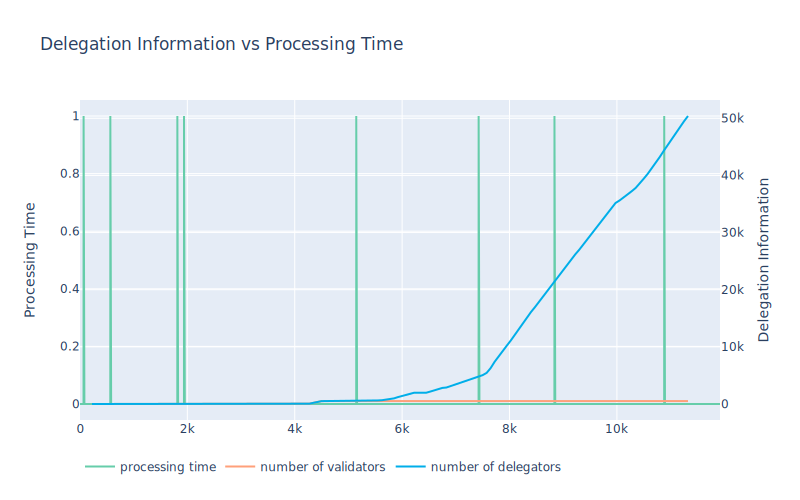

Statistics summary for block 1
       validators-number  delegators-number
count         149.000000         149.000000
mean          321.241611       10150.852349
std           246.036793       15115.735351
min             0.000000           0.000000
25%             2.000000           2.000000
50%           512.000000         824.000000
75%           513.000000       17889.000000
max           513.000000       50395.000000

Block 2
png graphs saved in ../../graphs/processing_time/stress_test_03_14/s0-leader/
html graphs saved in https://harmony-one.github.io/harmony-log-analysis/graphs/processing_time/stress_test_03_14/so-leader/1_delegation_vs_processing_time.html


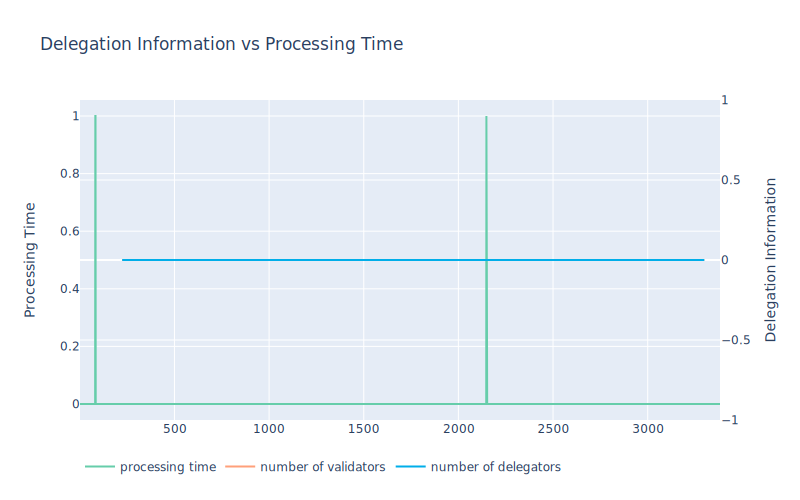

Statistics summary for block 2
       validators-number  delegators-number
count               42.0               42.0
mean                 0.0                0.0
std                  0.0                0.0
min                  0.0                0.0
25%                  0.0                0.0
50%                  0.0                0.0
75%                  0.0                0.0
max                  0.0                0.0



In [17]:
for idx in range(len(index)-1):
    
    print("Block "+str(idx+1))
    new = df.loc[index[idx]:index[idx+1]-1]
    new = new.drop_duplicates(subset = ['blockNum', 'message'], keep = "last")
    new['time_diff'] = new.groupby(['blockNum'])['time'].apply(lambda c: c.diff().dt.seconds)
    new.dropna(inplace = True)
    new.reset_index(inplace = True, drop = True) 
    
    new_del = df_delegation.loc[index_del[idx]:index_del[idx+1]-1]
    new_del = new_del.drop_duplicates(subset = ['block-number', 'epoch'], keep = "last")
    new_del.reset_index(inplace = True, drop = True)
   
    draw_graph(new, new_del, idx)
    
    print("Statistics summary for block " + str(idx+1))
    print("==================================")
    print(new_del[['validators-number','delegators-number']].describe())
    print("")

## s1-leader

In [18]:
log_dir = "../../logs/node_logs/stress_test_03_14/s1-leader/"
fig_dir = "../../graphs/processing_time/stress_test_03_14/s1-leader/"
html_dir = "../../docs/graphs/processing_time/stress_test_03_14/s1-leader/"
files = os.listdir(log_dir)
data = read_data(files, log_dir)
df = data_processing(data)
index = get_block_change_index(df)

delegations = read_delegations(files, log_dir)
df_delegation = delegation_processing(delegations)
index_del = get_epoch_change_index(df_delegation)

### draw delegation information vs processing time

Block 1
png graphs saved in ../../graphs/processing_time/stress_test_03_14/s1-leader/
html graphs saved in https://harmony-one.github.io/harmony-log-analysis/graphs/processing_time/stress_test_03_14/s1-leader/0_delegation_vs_processing_time.html


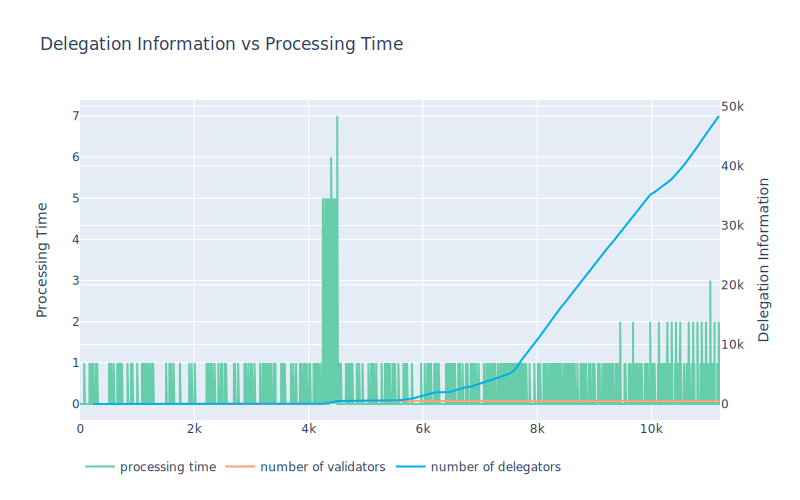

Statistics summary for block 1
       validators-number  delegators-number
count         147.000000         147.000000
mean          318.632653        9609.687075
std           246.683539       14479.119045
min             0.000000           0.000000
25%             2.000000           2.000000
50%           512.000000         754.000000
75%           513.000000       16518.500000
max           513.000000       48398.000000
Block 2
png graphs saved in ../../graphs/processing_time/stress_test_03_14/s1-leader/
html graphs saved in https://harmony-one.github.io/harmony-log-analysis/graphs/processing_time/stress_test_03_14/s1-leader/1_delegation_vs_processing_time.html


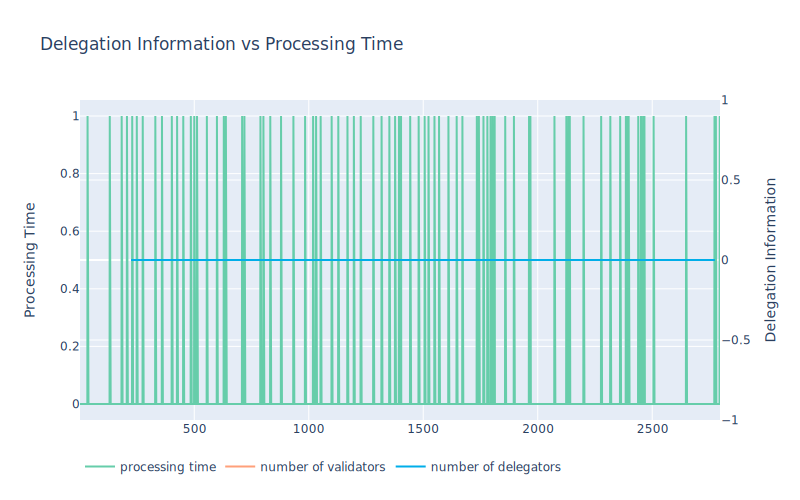

Statistics summary for block 2
       validators-number  delegators-number
count               35.0               35.0
mean                 0.0                0.0
std                  0.0                0.0
min                  0.0                0.0
25%                  0.0                0.0
50%                  0.0                0.0
75%                  0.0                0.0
max                  0.0                0.0


In [19]:
for idx in range(len(index)-1):
    
    print("Block "+str(idx+1))
    new = df.loc[index[idx]:index[idx+1]-1]
    new = new.drop_duplicates(subset = ['blockNum', 'message'], keep = "last")
    new['time_diff'] = new.groupby(['blockNum'])['time'].apply(lambda c: c.diff().dt.seconds)
    new.dropna(inplace = True)
    new.reset_index(inplace = True, drop = True) 
    
    new_del = df_delegation.loc[index_del[idx]:index_del[idx+1]-1]
    new_del = new_del.drop_duplicates(subset = ['block-number', 'epoch'], keep = "last")
    new_del.reset_index(inplace = True, drop = True)
   
    draw_graph(new, new_del, idx)
    
    print("Statistics summary for block " + str(idx+1))
    print("==================================")
    print(new_del[['validators-number','delegators-number']].describe())